In [0]:
!git clone https://github.com/rslim087a/track.git

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 20.47 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [0]:
!ls track

driving_log.csv  IMG


In [0]:
!pip3 install imgaug

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras 
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
import cv2
import pandas as pd
import random
import os
import ntpath #this module is used to break-down a path name
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [0]:
datadir = 'track'
columns = ['center','left','right',
           'steering_angle','throttle',
           'reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),
                   names = columns)
pd.set_option('display.max_colwidth',-1)
data.head(5)

,center,left,right,steering_angle,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] =  data['right'].apply(path_leaf)
data.head(5)

,center,left,right,steering_angle,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


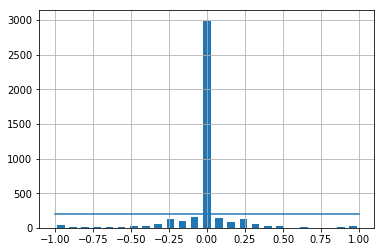

In [0]:
num_bins = 25
samples_per_bin = 200
hist,bins = np.histogram(data['steering_angle'],num_bins)
centre = (bins[:-1]+bins[1:])*0.5
plt.bar(centre,hist,width=0.05)
plt.plot((np.min(data['steering_angle']),
          np.max(data['steering_angle']))
         ,(samples_per_bin,samples_per_bin))
plt.grid()
print(bins)

removed: 2790
remaining: 1263


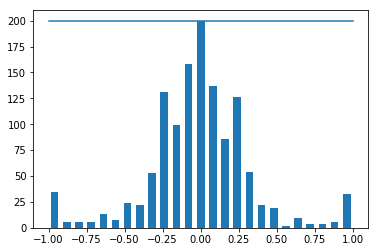

In [0]:
remove_list= []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering_angle'])):
    if data['steering_angle'][i]>=bins[j] and data['steering_angle'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:',len(data))

hist , _ = np.histogram(data['steering_angle'],num_bins)
plt.bar(centre,hist,width=0.05)
plt.plot((np.min(data['steering_angle']),np.max(data['steering_angle'])),
         (samples_per_bin,samples_per_bin))

In [0]:
def load_img_steering(datadir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir +'/IMG', data)

In [0]:
x_train,x_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,
                                                 random_state=6)

In [0]:
print('Training_samples:{}\nValid_samples:{}\n'.format(len(x_train),len(x_valid)))
print('Training_labels:{}\nValid_labels:{}\n'.format(len(y_train),len(y_valid)))

Training_samples:1010
Valid_samples:253

Training_labels:1010
Valid_labels:253



Text(0.5, 1.0, 'valdatiojn_set')

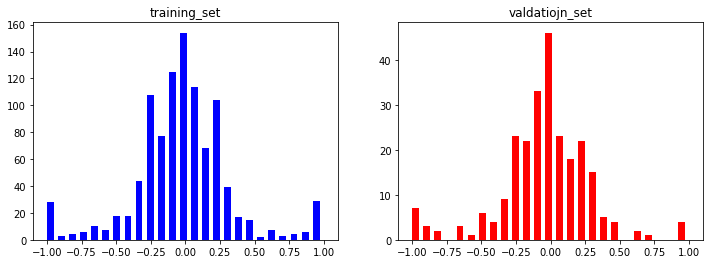

In [0]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins = num_bins, width=0.05,color='b')
axes[0].set_title('training_set')
axes[1].hist(y_valid, bins = num_bins, width=0.05,color='r')
axes[1].set_title('valdatiojn_set')


In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed')

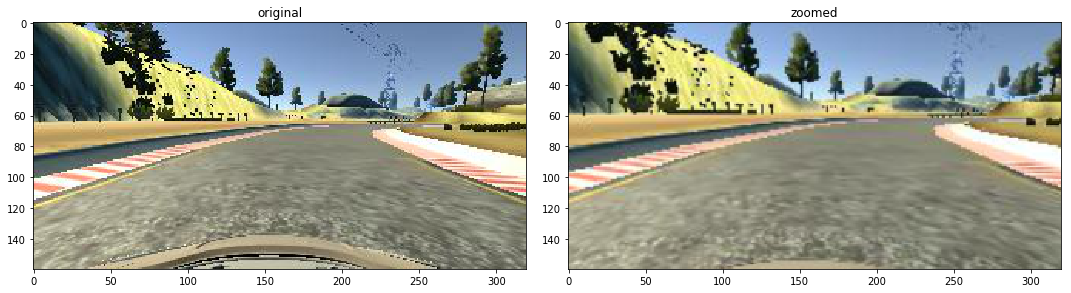

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original')
axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent = {'x':(-0.1,0.1),'y':(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'panned')

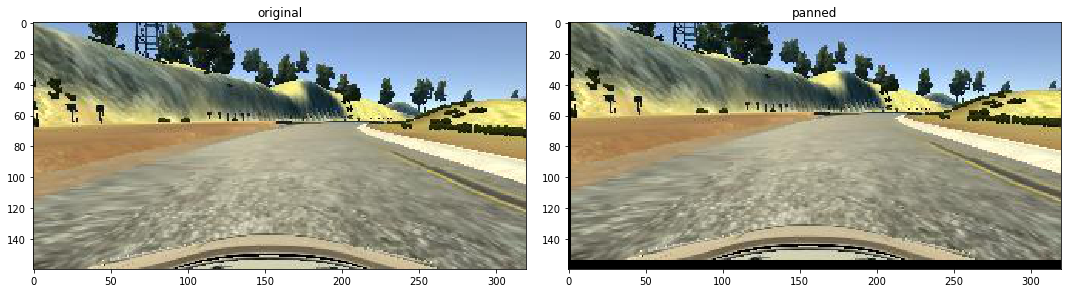

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original')
axs[1].imshow(panned_image)
axs[1].set_title('panned')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'brightness altered image')

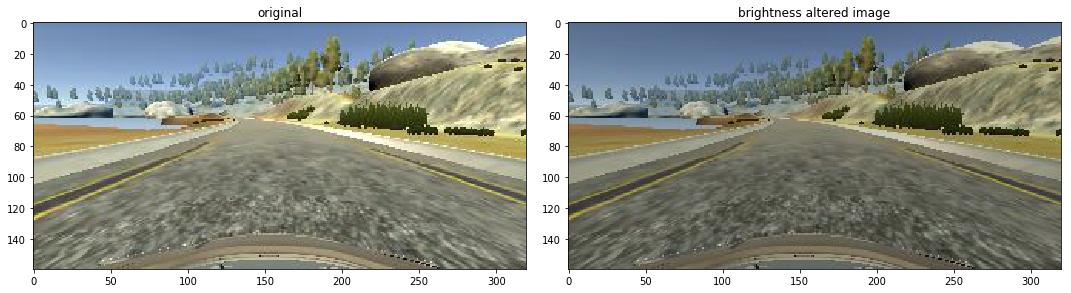

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('brightness altered image')

In [0]:
def image_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'flipped_image -Steering_angle:-0.0')

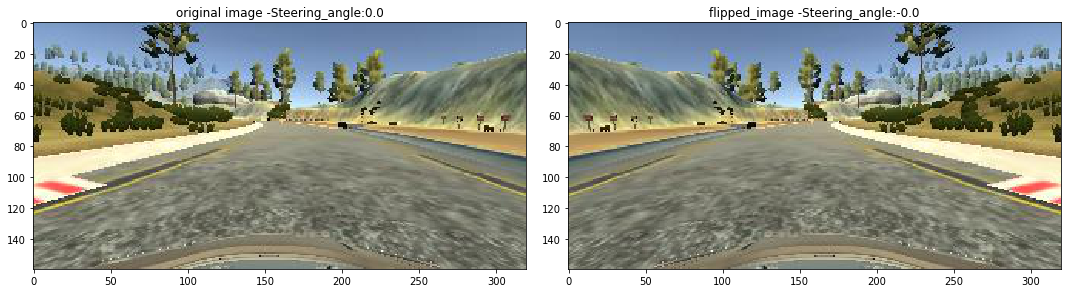

In [0]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = image_random_flip(original_image,steering_angle)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image -'+'Steering_angle:'+str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('flipped_image -'+'Steering_angle:'+str(flipped_steering_angle))

In [0]:
def random_augment(image,steering_angle):
  image = mpimg.imread(image)
  if np.random.rand()<0.5:
    image = pan(image)
  if np.random.rand()<0.5:
    image = zoom(image)
  if np.random.rand()<0.5:
    image = img_random_brightness(image)
  if np.random.rand()<0.5:
    image, steering_angle = image_random_flip(image,steering_angle)
  return image, steering_angle  

In [0]:
ncol = 2
nrow = 10
fig,axes = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
  random_num = random.randint(0,len(image_paths)-1)
  random_image = image_paths[random_num]
  random_steering = steerings[random_num]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axes[i][0].imshow(original_image)
  axes[i][0].set_title('original image')
  
  
  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title('augmented image')

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  
  return img

Text(0.5, 1.0, 'preprocessed')

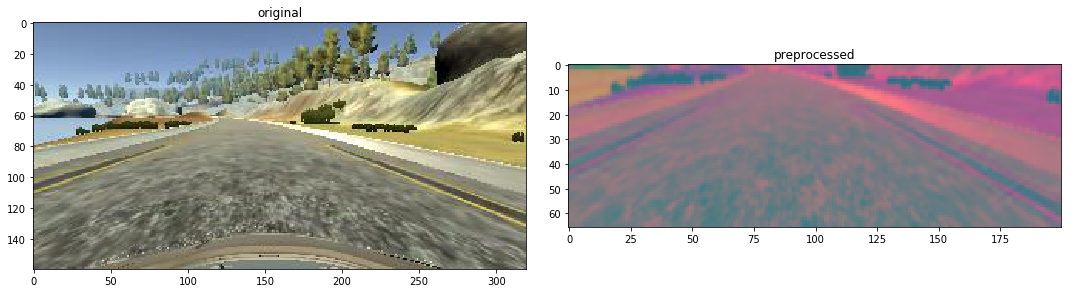

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed')

In [0]:
x_train = np.array(list(map(img_preprocess,x_train)))
x_valid = np.array(list(map(img_preprocess,x_valid)))

(1010, 66, 200, 3)


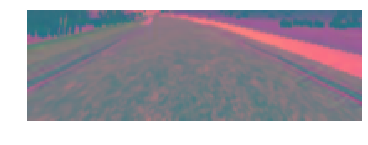

In [0]:
plt.imshow(x_train[random.randint(0,len(x_train-1))])
plt.axis('off')
print(x_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,5,5,subsample=(2,2), input_shape=(66,200,3),activation='elu'))
  model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50,activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Dense(10,activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  model.compile(Adam(lr=0.01),loss='mse')
  return model

In [0]:
model = nvidia_model()
model.summary()

W0619 10:45:11.880007 140118651656064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
W0619 10:45:11.924768 140118651656064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 10:45:12.066747 140118651656064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [0]:
h = model.fit(x_train,y_train,epochs=50,verbose=1,validation_data=(x_valid,y_valid),batch_size=100,shuffle=1)

W0619 10:45:12.577791 140118651656064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1010 samples, validate on 253 samples
Epoch 1/50
1010/1010 [==============================] - 7s 7ms/step - loss: 151815.7595 - val_loss: 5.3164
Epoch 2/50
1010/1010 [==============================] - 0s 436us/step - loss: 396.9183 - val_loss: 1.6750
Epoch 3/50
1010/1010 [==============================] - 0s 437us/step - loss: 66.9367 - val_loss: 1.2986
Epoch 4/50
1010/1010 [==============================] - 0s 442us/step - loss: 58.2582 - val_loss: 1.2017
Epoch 5/50
1010/1010 [==============================] - 0s 442us/step - loss: 25.8370 - val_loss: 1.2004
Epoch 6/50
1010/1010 [==============================] - 0s 438us/step - loss: 15.2901 - val_loss: 1.1828
Epoch 7/50
1010/1010 [==============================] - 0s 452us/step - loss: 13.6343 - val_loss: 1.1540
Epoch 8/50
1010/1010 [==============================] - 0s 439us/step - loss: 10.8900 - val_loss: 1.1398
Epoch 9/50
1010/1010 [==============================] - 0s 451us/step - loss: 10.9095 - val_loss: 1.1041
Epoch

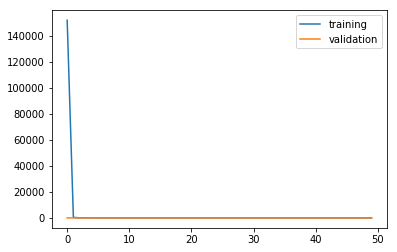

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training','validation'])
plt.show()

In [0]:
model.save('model.h5')


In [0]:
from google.colab import files
files.download('model.h5')